In [1]:
import torch
import pandas as pd
import numpy as np
from models.resnetv2 import ResNet50, ResNet101
from torchvision import datasets, transforms
from PIL import Image
import torch.utils.data as data
from melanoma.melanoma_loader import Melanoma_loader
import matplotlib.pyplot as plt

# UTILS

In [2]:
from PIL import Image

WIDTH = 256
HEIGHT = 256
ROOT = "data/train/train/"

def stacked_img(img_path, extra_img):
    img = Image.open(ROOT + img_path + ".jpg")

    new_im = Image.new('RGB', (2 * WIDTH, HEIGHT))
    new_im.paste(img, (0, 0))
    new_im.paste(extra_img, (WIDTH, 0))
    return new_im

In [3]:
def iterate_class(dataset, find_melanoma=1):
    for idx in range(len(dataset)):
        if dataset[idx][1] == find_melanoma:
            yield dataset[idx][0].view(1, 3, 256, 256), dataset.lookup_path(idx)

# END UTILS

In [4]:
# melanoma model
# !wget -O model_melanoma https://www.dropbox.com/s/5gfs44hf282l22r/ckpt_epoch_18.pth?dl=0

In [5]:
path_to_model = 'model_melanoma'

In [6]:
model = ResNet50(out_features = 2, freeze = True, in_channels = 3)
checkpoint1 = torch.load(path_to_model, map_location='cpu')
msg1 = model.load_state_dict(checkpoint1['model'], strict=False)
msg1

<All keys matched successfully>

In [7]:
dataset = Melanoma_loader(root = "data/train/train", ann_path = "melanoma/data/test_set.csv", 
                          transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((256, 256)),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])]))

In [8]:
generator = iterate_class(dataset)

model = model.eval()

In [9]:
test_tensor, path = next(generator)

## LRP

In [10]:
from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import ResNetCanonizer
from zennit.attribution import Gradient

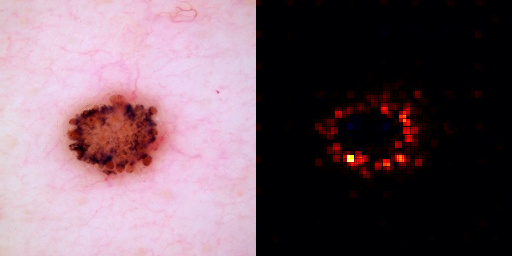

In [11]:
# use the ResNet-specific canonizer
canonizer = ResNetCanonizer()

# create a composite, specifying the canonizers
composite = EpsilonPlusFlat(canonizers=[canonizer])

# target = torch.eye(2)[[img[1]]] * out[0, 1]
target = torch.eye(2)[[1]]
# https://github.com/chr5tphr/zennit/blob/master/share/example/feed_forward.py#L149

# create the attributor, specifying model and composite
with Gradient(model=model, composite=composite) as attributor:
    # compute the model output and attribution
    output, attribution = attributor(test_tensor, target)
    
from zennit.image import imgify
# sum over the channels
relevance = attribution.sum(1)

# create an image of the visualize attribution
img = imgify(relevance, symmetric=True, cmap='coldnhot')
new_img = stacked_img(path, img)
# show the image
display(new_img)

LRP explained: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf

# CRP

In [14]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image
import numpy as np

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model.eval()


sample, path = next(generator)

In [15]:

from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept

cc = ChannelConcept()
attribution = CondAttribution(model)

True 6


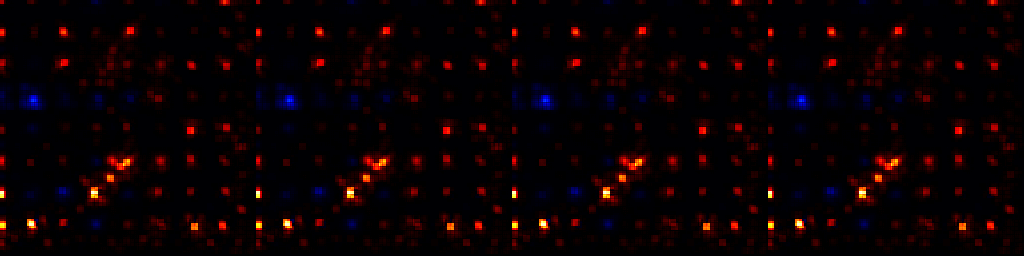

In [24]:
from crp.helper import get_layer_names

# compute heatmap wrt. output 46 (green lizard class)
concept_ids = list(range(4))
# conditions = [{'backbone.conv1': [ids], 'y': [1]} for ids in concept_ids]
conditions = [{'layer1.0.conv1': [ids], 'y': [1]} for ids in concept_ids]
# zennit requires gradients
sample.requires_grad = True
attr = attribution(sample, conditions, composite)

# or use a dictionary for mask_map

heatmaps, _, _, _ = attribution(sample, conditions, composite)
from crp.image import imgify

print(torch.equal(attr[0], heatmaps), itera)

img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
display(img)
                                                       
# new_img = stacked_img(path, img)
# # show the image
# display(new_img)

True 7


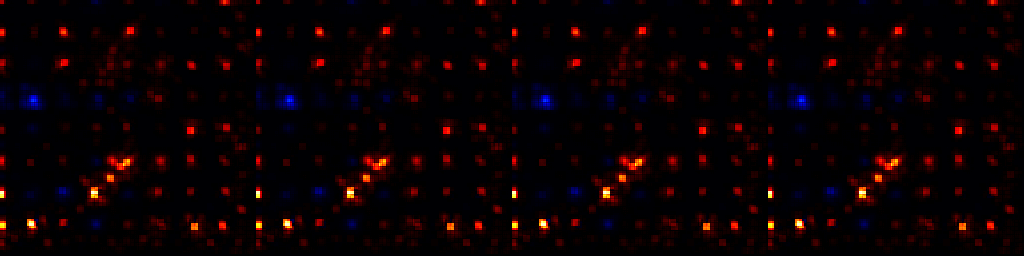

In [25]:
from crp.helper import get_layer_names

# compute heatmap wrt. output 46 (green lizard class)
concept_ids = list(range(4))
# conditions = [{'backbone.conv1': [ids], 'y': [1]} for ids in concept_ids]
conditions = [{'layer1.0.conv1': [range(10)], 'y': [1]} for ids in concept_ids]
itera += 1
# zennit requires gradients
sample.requires_grad = True
attr = attribution(sample, conditions, composite)

# or use a dictionary for mask_map

heatmaps, _, _, _ = attribution(sample, conditions, composite)
from crp.image import imgify

print(torch.equal(attr[0], heatmaps), itera)

img = imgify(heatmaps, symmetric=True, cmap='coldnhot', grid=(1, len(heatmaps)))
display(img)
                                                       
# new_img = stacked_img(path, img)
# # show the image
# display(new_img)

In [18]:
canonizer.canonizers

(<zennit.canonizers.SequentialMergeBatchNorm at 0x7fb842512260>,
 <zennit.torchvision.ResNetBasicBlockCanonizer at 0x7fb842511630>)

In [19]:
canonizer.canonizers[1]._attribute_map("layer1.0", model.layer1[0])

AttributeError: 'ResNet50' object has no attribute 'layer1'

In [ ]:
len(canonizer.canonizers[1].apply(model))

In [ ]:
canonizer.canonizers[1].apply(model)

In [ ]:
composite.handles